## Integrate model inter-cluster with three clustering

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import copy

import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

from utils import filter_out_isolate, draw_cluster_info, draw_isolate_cluster_info, draw_trainer_info, print_data_info


In [3]:
import inspect
import torch
from torch_geometric.utils import scatter_

special_args = [
    'edge_index', 'edge_index_i', 'edge_index_j', 'size', 'size_i', 'size_j'
]
__size_error_msg__ = ('All tensors which should get mapped to the same source '
                      'or target nodes must be of same size in dimension 0.')

is_python2 = sys.version_info[0] < 3
getargspec = inspect.getargspec if is_python2 else inspect.getfullargspec


class MessagePassing(torch.nn.Module):
    r"""Base class for creating message passing layers

    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{i,j}\right) \right),

    where :math:`\square` denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean or max, and :math:`\gamma_{\mathbf{\Theta}}`
    and :math:`\phi_{\mathbf{\Theta}}` denote differentiable functions such as
    MLPs.
    See `here <https://pytorch-geometric.readthedocs.io/en/latest/notes/
    create_gnn.html>`__ for the accompanying tutorial.

    Args:
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"` or :obj:`"max"`).
            (default: :obj:`"add"`)
        flow (string, optional): The flow direction of message passing
            (:obj:`"source_to_target"` or :obj:`"target_to_source"`).
            (default: :obj:`"source_to_target"`)
    """

    def __init__(self, aggr='add', flow='source_to_target'):
        super(MessagePassing, self).__init__()

        self.aggr = aggr
        assert self.aggr in ['add', 'mean', 'max']

        self.flow = flow
        # give a warning if the option is not valid
        assert self.flow in ['source_to_target', 'target_to_source']

        self.__message_args__ = getargspec(self.message)[0][1:]
        # we will have [x_j, norm ] put into self.__message_args__
        
        self.__special_args__ = [(i, arg)
                                 for i, arg in enumerate(self.__message_args__)
                                 if arg in special_args]
        
        self.__message_args__ = [arg for arg in self.__message_args__ if arg not in special_args]
        
        self.__update_args__ = getargspec(self.update)[0][2:]
        # empty, since there is nothing beyond: agg_out

#     function call: res = self.propagate(edge_index, x=x, norm=norm)
    def propagate(self, edge_index, size=None, **kwargs):
        r"""The initial call to start propagating messages.

        Args:
            edge_index (Tensor): The indices of a general (sparse) assignment
                matrix with shape :obj:`[N, M]` (can be directed or
                undirected).
            size (list or tuple, optional): The size :obj:`[N, M]` of the
                assignment matrix. If set to :obj:`None`, the size is tried to
                get automatically inferred. (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct messages
                and to update node embeddings.
        """
        dim = 0
        size = [None, None] if size is None else list(size)
        assert len(size) == 2

        i, j = (0, 1) if self.flow == 'target_to_source' else (1, 0)
        # here (i, j) == (1, 0)
        ij = {"_i": i, "_j": j}

        message_args = []
        
        for arg in self.__message_args__:
#             arg[-2] == '_j'
            if arg[-2:] in ij.keys():
#                 tmp == x, is inside the dwargs
                tmp = kwargs.get(arg[:-2], None)   # get the value of the parameter
                if tmp is None:  # pragma: no cover
                    message_args.append(tmp)
                else:
                    idx = ij[arg[-2:]]    # idx == 0
                    if isinstance(tmp, tuple) or isinstance(tmp, list):
                        assert len(tmp) == 2
                        if tmp[1 - idx] is not None:
                            if size[1 - idx] is None:
                                size[1 - idx] = tmp[1 - idx].size(dim)
                            if size[1 - idx] != tmp[1 - idx].size(dim):
                                raise ValueError(__size_error_msg__)
                        tmp = tmp[idx]
                    
                    if tmp is None:
                        message_args.append(tmp)
                    else:
                        if size[idx] is None:
                            size[idx] = tmp.size(dim)
                        if size[idx] != tmp.size(dim):
                            raise ValueError(__size_error_msg__)
                        # dim == 0, we duplicate part of the embeddings x by using the edge_index[idx]
#                         print('Inside the propagate, edge_index[idx]: \n', edge_index[idx].shape, '\n', edge_index[idx])
                        tmp = torch.index_select(tmp, dim, edge_index[idx])
                        message_args.append(tmp)   # here we append x from the kwargs
            else:
                message_args.append(kwargs.get(arg, None))   # here we append norm
        
#         message_args are: x_j, norm 
#         size:  [8, None] 
#         kwargs:  dict_keys(['x', 'norm']) 
#         special keys:  []
        
        size[0] = size[1] if size[0] is None else size[0]
        size[1] = size[0] if size[1] is None else size[1]

        kwargs['edge_index'] = edge_index
        kwargs['size'] = size
        
        # for now self.__special_args__ is empty
        for (idx, arg) in self.__special_args__:
            if arg[-2:] in ij.keys():
                # here we will change the content of x (features)
                # features will be corresponds to edge_index
                message_args.insert(idx, kwargs[arg[:-2]][ij[arg[-2:]]])
            else:
                message_args.insert(idx, kwargs[arg])

        update_args = [kwargs[arg] for arg in self.__update_args__]
#         message_args are: x_j, norm 
        out = self.message(*message_args)
        # here i = 1, edge_index is the target endpoint of an edge, size[i] is the size of target endpoints
        out = scatter_(self.aggr, out, edge_index[i], dim_size=size[i])
        out = self.update(out, *update_args)
        return out

    def message(self, x_j):  # pragma: no cover
        r"""Constructs messages in analogy to :math:`\phi_{\mathbf{\Theta}}`
        for each edge in :math:`(i,j) \in \mathcal{E}`.
        Can take any argument which was initially passed to :meth:`propagate`.
        In addition, features can be lifted to the source node :math:`i` and
        target node :math:`j` by appending :obj:`_i` or :obj:`_j` to the
        variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`."""

        return x_j

    def update(self, aggr_out):  # pragma: no cover
        r"""Updates node embeddings in analogy to
        :math:`\gamma_{\mathbf{\Theta}}` for each node
        :math:`i \in \mathcal{V}`.
        Takes in the output of aggregation as first argument and any argument
        which was initially passed to :meth:`propagate`."""

        return aggr_out


In [4]:
import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops

### ================== Definition of custom GCN

def glorot(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        tensor.data.uniform_(-stdv, stdv)
#         tensor.data.fill_(1.0)   # trivial example
        
def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

class custom_GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, improved=False, cached=False,
                 bias=True, **kwargs):
        super().__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)
        self.cached_result = None
        self.cached_num_edges = None


    @staticmethod
    def norm(edge_index, num_nodes, edge_weight=None, improved=False, dtype=None):
        
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
        
        fill_value = 1 if not improved else 2
        
        edge_index, edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)
        
        row, col = edge_index   
        # row includes the starting points of the edges  (first row of edge_index)
        # col includes the ending points of the edges   (second row of edge_index)

        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # row records the source nodes, which is the index we are trying to add
        # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops
        
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        
#         print('whole GCN training normalized_edge_weight: \n', normalized_edge_weight)
        return edge_index, normalized_edge_weight

    def forward(self, x, edge_index, edge_weight = None):
        """"""
#         print('current weight is: ')
#         print(self.weight)
#         print('current bias is: ')
#         print(self.bias)
        
        x = torch.matmul(x, self.weight)   # update x (embeddings)
        
#         print('inside custom_GCN, edge_index: ', edge_index.shape, '\n', edge_index)
        res = self.propagate(edge_index, x = x, norm = edge_weight)
        return res

    # self is the first parameter of the message func
    def message(self, x_j, norm):
        # in source code of the MessagePassing:
#         self.__message_args__ = getargspec(self.message)[0][1:]  : will be initialized as [x_j, norm]
        
        # view is to reshape the tensor, here make it only a single column
        # use the normalized weights multiplied by the feature of the target nodes
        '''
        For each of extended edge_index:(x_i, x_j), assume there is N such edges
        x_j of shape (N, k) , assume there is k features, value along each row are the same
        norm of shape (1, m), assume there is m edges (including self loops), 1-D tensor
        '''
#         print('inside the message custom_GCN: norm \n', norm.shape, '\n', norm)
#         print('inside the message custom_GCN: x_j \n', x_j.shape, '\n', x_j)
        res = norm.view(-1, 1) * x_j  # use the element wise multiplication
        return res

    def update(self, aggr_out):
        # update the embeddings of each node
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)



In [5]:
### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [16, 16], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        # one trivial example
#         self.conv1 = custom_GCNConv(in_channels, out_channels)
#         self.conv2 = GCNConv(16, dataset.num_classes)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        for i, _ in enumerate(self.input_layers[:-1]):
            self.layers.append(custom_GCNConv(self.input_layers[i],self.input_layers[i+1]))
        self.layers = ListModule(*self.layers)

    # change the dropout positions: 
    def forward(self, edge_index, features, edge_weights = None):
        if len(self.layers) > 1:
            for i in range(len(self.layers)-1):
                features = F.relu(self.layers[i](features, edge_index, edge_weights))
#                 if i>0:
                features = F.dropout(features, p = self.dropout, training = self.training)
                    
            features = self.layers[len(self.layers)-1](features, edge_index, edge_weights)
        else:
            features = self.layers[0](features, edge_index, edge_weights)    # for a single layer case

        predictions = F.log_softmax(features, dim=1)
        return predictions

In [6]:
class single_Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(single_Net, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        # here we just initialize the model
        self.conv1 = custom_GCNConv(self.in_channels, self.out_channels)
        

    def forward(self, edge_index, features, edge_weights = None):
        # call the instance of the custom_GCNConv
        z = self.conv1(features, edge_index, edge_weights)    # for a single layer case, z is embeddings
#         print('embeddings inside the net work model, result is: \n', z)
        
        predictions = F.log_softmax(z, dim=1)
#         print('calibration inside the net work model, result is: \n', predictions)
        return predictions

### Partition GCN

#### Partition method

In [58]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, partition_num = 2):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        """
        tmp = edge_index.t().numpy().tolist()
        self.graph = nx.from_edgelist(tmp)
        self.features = features
        self.label = label
        self.partition_num = partition_num
        self._set_sizes()
        self.edge_index = edge_index
        # this will get the edge weights in a complete graph
        self.get_edge_weight(self.edge_index, self.node_count)

    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
        
    def get_edge_weight(self, edge_index, num_nodes, edge_weight=None, improved=False, dtype=None):
        
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
        
        fill_value = 1 if not improved else 2
        # there are num_nodes self-loop edges added after the edge_index
        edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, fill_value, num_nodes)
        
        row, col = edge_index   
        # row includes the starting points of the edges  (first row of edge_index)
        # col includes the ending points of the edges   (second row of edge_index)

        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # row records the source nodes, which is the index we are trying to add
        # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops
        
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        self.edge_index_global_self_loops = edge_index
        # transfer from tensor to the numpy to construct the dict for the edge_weights
        edge_index = edge_index.t().numpy()
        normalized_edge_weight = normalized_edge_weight.numpy()
        num_edge, _ = edge_index.shape
        # this info can also be stored as matrix considering the memory, depends whether the matrix is sparse or not
        self.edge_weight_global_dict = {(edge_index[i][0], edge_index[i][1]) : normalized_edge_weight[i] for i in range(num_edge)}
        
#         print('after adding self-loops, edge_index is', edge_index)
        self.edge_weight_global = [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in edge_index ]
#         print('a list of the global weights : \n', self.edge_weight_global )
    
        
    def decompose(self, test_ratio, validation_ratio):
        """
        Decomposing the graph, partitioning the features and label, creating Torch arrays.
        """
        # to keep the edge weights of the original whole graph:
        
        self.metis_clustering()
#         self.random_clustering()
        self._set_inter_clusters()
        self.general_global_isolate_partitioning(test_ratio, validation_ratio)
        # for the wholeGCNTraniner Purpose
        self.general_accumulate_partition()
        
    def _set_inter_clusters(self):
        # independent of the clustering method:
        self.intersect_cluster = []
        for i in range(1, self.partition_num):
            tmp = [(m, n) for m, n in zip(self.clusters, self.clusters[i:])]
            self.intersect_cluster.extend(tmp)
        # initialize as the totla edges (without duplicates) all over the whole graph
        self.macro_inter_edges = set(self.graph.edges())   # a sequence of tuple to indicate edges

    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self):
        """
        Random clustering the nodes.
        """
        self.clusters = [cluster for cluster in range(self.partition_num)]
        # randomly divide into two clusters
        self.cluster_membership = {node: random.choice(self.clusters) for node in self.graph.nodes()}

    def metis_clustering(self):
        """
        Clustering the graph with Metis. For details see:
        """
        (st, parts) = metis.part_graph(self.graph, self.partition_num)
        self.clusters = list(set(parts))
        self.cluster_membership = {node: membership for node, membership in enumerate(parts)}


    def general_global_isolate_partitioning(self, test_ratio, validation_ratio):
        """
        Creating data partitions and train-test splits.
        """
        self.type = 'general'
        relative_test_ratio = (test_ratio) / (1 - validation_ratio)
        self.sg_nodes_global = {}
        self.sg_edges_global = {}
        self.sg_subgraph = {}
        
        self.sg_model_nodes_global = {}
        self.sg_validation_nodes_global = {}
        self.sg_train_nodes_global = {}
        self.sg_test_nodes_global = {}
        
        # keep the info of each cluster:
        self.info_isolate_cluster_size = {}
        self.info_model_cluster_size = {}
        self.info_validation_cluster_size = {}
        self.info_train_cluster_size = {}
        self.info_test_cluster_size = {}
        
        for cluster in self.clusters:
            
            self.sg_subgraph[cluster] = self.graph.subgraph([node for node in sorted(self.graph.nodes()) if self.cluster_membership[node] == cluster])
            
            self.sg_nodes_global[cluster] = sorted(node for node in self.sg_subgraph[cluster].nodes())
            
            self.sg_edges_global[cluster] = {edge for edge in self.sg_subgraph[cluster].edges()}
            # substract two possible directions of edges
            self.macro_inter_edges -= set([(edge[0], edge[1]) for edge in self.sg_subgraph[cluster].edges()] +  \
                                       [(edge[1], edge[0]) for edge in self.sg_subgraph[cluster].edges()])
            
            self.sg_model_nodes_global[cluster], self.sg_validation_nodes_global[cluster] = train_test_split(self.sg_nodes_global[cluster], test_size = validation_ratio)
            self.sg_model_nodes_global[cluster] = sorted(self.sg_model_nodes_global[cluster])
            self.sg_validation_nodes_global[cluster] = sorted(self.sg_validation_nodes_global[cluster])
            
            self.sg_train_nodes_global[cluster], self.sg_test_nodes_global[cluster] = train_test_split(self.sg_model_nodes_global[cluster], test_size = relative_test_ratio)
            self.sg_train_nodes_global[cluster] = sorted(self.sg_train_nodes_global[cluster])
            self.sg_test_nodes_global[cluster] = sorted(self.sg_test_nodes_global[cluster])
            
            # record the information of each cluster:
            self.info_isolate_cluster_size[cluster] = len(self.sg_nodes_global[cluster])
            self.info_model_cluster_size[cluster] = len(self.sg_model_nodes_global[cluster])
            self.info_validation_cluster_size[cluster] = len(self.sg_validation_nodes_global[cluster])
            
            self.info_train_cluster_size[cluster] = len(self.sg_train_nodes_global[cluster])
            self.info_test_cluster_size[cluster] = len(self.sg_test_nodes_global[cluster])
    
    # accumulate all the train, test, and validation nodes 
    def general_accumulate_partition(self):
        # sum up different parts of the data
#         self.total_sg_train_nodes_global = sorted(chain.from_iterable(self.sg_train_nodes_global[cluster] for cluster in self.clusters))
#         self.total_sg_test_nodes_global = sorted(chain.from_iterable(self.sg_test_nodes_global[cluster] for cluster in self.clusters)) 
        self.total_sg_train_nodes_global = sorted(self.sg_train_nodes_global[0])
        self.total_sg_test_nodes_global = sorted(self.sg_test_nodes_global[0])
        self.total_sg_validation_nodes_global = sorted(chain.from_iterable(self.sg_validation_nodes_global[cluster] for cluster in self.clusters))
    
    
    def general_isolate_clustering(self, k):
        """
            Still find the train batch, but cannot exceed the scope of the isolated clustering
        """
        self.sg_mini_edges_global = {}
        self.sg_mini_nodes_global = {}
        
        self.sg_mini_train_nodes_local = {}
        self.sg_mini_edges_local = {}
        self.sg_mini_edge_weight_local = {}
        self.sg_mini_features = {}
        self.sg_mini_labels = {}
        
        self.neighbor = defaultdict(dict)   # keep layer nodes of each layer
        self.accum_neighbor = defaultdict(set)
        
        self.info_train_batch_size = {}
        
        for cluster in self.clusters:
            self.neighbor[cluster] = {0 : set(self.sg_train_nodes_global[cluster])}
            for layer in range(k):
                # first accumulate last layer
                self.accum_neighbor[cluster] |= self.neighbor[cluster][layer]
                tmp_level = set()
                for node in self.neighbor[cluster][layer]:
                    tmp_level |= set(self.sg_subgraph[cluster].neighbors(node))
                # add the new layer of neighbors
                self.neighbor[cluster][layer+1] = tmp_level - self.accum_neighbor[cluster]
#                 print('layer ' + str(layer + 1) + ' : ', self.neighbor[cluster][layer+1])
            # the most outside layer: kth layer will be added:
            self.accum_neighbor[cluster] |= self.neighbor[cluster][k]
            batch_subgraph = self.sg_subgraph[cluster].subgraph(self.accum_neighbor[cluster])
            
#             print('nodes for cluster ' + str(cluster) + ' are: ', sorted(node for node in batch_subgraph.nodes()))
#             print('edges for cluster ' + str(cluster) + ' are: ', {edge for edge in batch_subgraph.edges()} ) 
            
            
            # first select all the overlapping nodes of the train nodes
            self.sg_mini_edges_global[cluster] = {edge for edge in batch_subgraph.edges()}
            self.sg_mini_nodes_global[cluster] = sorted(node for node in batch_subgraph.nodes())
            
            
            mini_mapper = {node: i for i, node in enumerate(self.sg_mini_nodes_global[cluster])}
            sg_node_index_local = sorted(mini_mapper.values())
            
            self.sg_mini_edges_local[cluster] = \
                           [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in self.sg_mini_edges_global[cluster] ] + \
                           [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in self.sg_mini_edges_global[cluster] ] + \
                           [ [i, i] for i in sg_node_index_local ]  
            
            self.sg_mini_edge_weight_local[cluster] = \
                            [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_mini_edges_global[cluster] ] + \
                            [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_mini_edges_global[cluster] ] + \
                            [ self.edge_weight_global_dict[(i, i)] for i in self.sg_mini_nodes_global[cluster] ]
            
#             print('train nodes global for the cluster # ' + str(cluster), self.sg_train_nodes_global[cluster])
            self.sg_mini_train_nodes_local[cluster] = [ mini_mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            
            self.sg_mini_features[cluster] = self.features[self.sg_mini_nodes_global[cluster],:]
            self.sg_mini_labels[cluster] = self.label[self.sg_mini_nodes_global[cluster]]
            
            # record information 
            self.info_train_batch_size[cluster] = len(self.sg_mini_nodes_global[cluster])
        
        # at last, out of all the cluster loop do the data transfer
        self.transfer_edges_and_nodes()
        self.mini_transfer_edges_and_nodes()
        
    def print_neighbor_list(self):
        for cluster in self.clusters:
            train_set = set(self.sg_train_nodes_global[cluster])
            for node in train_set:
                print('node ' + str(node) + ' : ', list(self.graph.neighbors(node)), type(self.graph.neighbors(node)))
                
    def get_train_neighbor(self, k):
        """
            get a collection of nodes: including k layers of neighbors together with original isolate cluster nodes
            k: number of layers of neighbors
        """
        # this self.neighbor keeps a record: in each cluster, the nodes of different layer of neighbors
        self.neighbor = defaultdict(dict)   # keep layer nodes of each layer
        self.accum_neighbor = defaultdict(set)
        for cluster in self.clusters:
            self.neighbor[cluster] = {0 : set(self.sg_train_nodes_global[cluster])}
            
            for layer in range(k):
                # first accumulate last layer
                self.accum_neighbor[cluster] |= self.neighbor[cluster][layer]
                tmp_level = set()
                for node in self.neighbor[cluster][layer]:
                    tmp_level |= set(self.graph.neighbors(node))
                # add the new layer of neighbors
                self.neighbor[cluster][layer+1] = tmp_level - self.accum_neighbor[cluster]
#                 print('layer ' + str(layer + 1) + ' : ', self.neighbor[cluster][layer+1])
            # the most outside layer: kth layer will be added:
            self.accum_neighbor[cluster] |= self.neighbor[cluster][k]
#             print('accumulating ' + str(k) + ' layers: ', self.accum_neighbor[cluster])
            # after getting the train k layer neighbor nodes, generating the graph
            batch_subgraph = self.graph.subgraph(self.accum_neighbor[cluster])
            print('nodes for cluster ' + str(cluster) + ' are: ', sorted(node for node in batch_subgraph.nodes()))
            
            print('edges for cluster ' + str(cluster) + ' are: ', {edge for edge in batch_subgraph.edges()} ) 
        
            
    # select the training nodes as the mini-batch for each cluster
    def mini_batch_train_sample(self, cluster, k, frac = 1):
        self.neighbor[cluster] = {0 : set(self.sg_train_nodes_global[cluster])}
        for layer in range(k):
            # first accumulate last layer
            self.accum_neighbor[cluster] |= self.neighbor[cluster][layer]
            tmp_level = set()
            for node in self.neighbor[cluster][layer]:
                tmp_level |= set(self.graph.neighbors(node))
            # add the new layer of neighbors
            tmp_level -= self.accum_neighbor[cluster]
            # each layer will only contains partial nodes from the previous layer
            self.neighbor[cluster][layer+1] = set(random.sample(tmp_level, int(len(tmp_level) * frac) ) ) if 0 < frac < 1 else tmp_level
#                 print('layer ' + str(layer + 1) + ' : ', self.neighbor[cluster][layer+1])
        # the most outside layer: kth layer will be added:
        self.accum_neighbor[cluster] |= self.neighbor[cluster][k]
        
    def mini_batch_train_clustering(self, k, fraction = 0.5):
        """
            create the mini-batch focused on the train nodes only
            Include a total of k layers of neighbors of the original training nodes
            k: number of layers of neighbors for each training node
        """
        self.sg_mini_edges_global = {}
        self.sg_mini_nodes_global = {}
        
        self.sg_mini_train_nodes_local = {}
        self.sg_mini_edges_local = {}
        self.sg_mini_edge_weight_local = {}
        self.sg_mini_features = {}
        self.sg_mini_labels = {}
        
        self.neighbor = defaultdict(dict)   # keep layer nodes of each layer
        self.accum_neighbor = defaultdict(set)
        
        self.info_train_batch_size = {}
        
        for cluster in self.clusters:
            self.mini_batch_train_sample(cluster, k, frac = fraction)
            batch_subgraph = self.graph.subgraph(self.accum_neighbor[cluster])
            
#             print('nodes for cluster ' + str(cluster) + ' are: ', sorted(node for node in batch_subgraph.nodes()))
#             print('edges for cluster ' + str(cluster) + ' are: ', {edge for edge in batch_subgraph.edges()} ) 
            
            # first select all the overlapping nodes of the train nodes
            self.sg_mini_edges_global[cluster] = {edge for edge in batch_subgraph.edges()}
            self.sg_mini_nodes_global[cluster] = sorted(node for node in batch_subgraph.nodes())
            
            
            mini_mapper = {node: i for i, node in enumerate(self.sg_mini_nodes_global[cluster])}
            sg_node_index_local = sorted(mini_mapper.values())
            
            self.sg_mini_edges_local[cluster] = \
                           [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in self.sg_mini_edges_global[cluster] ] + \
                           [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in self.sg_mini_edges_global[cluster] ] + \
                           [ [i, i] for i in sg_node_index_local ]  
            
            self.sg_mini_edge_weight_local[cluster] = \
                            [ self.edge_weight_global_dict[(edge[0], edge[1])] for edge in self.sg_mini_edges_global[cluster] ] + \
                            [ self.edge_weight_global_dict[(edge[1], edge[0])] for edge in self.sg_mini_edges_global[cluster] ] + \
                            [ self.edge_weight_global_dict[(i, i)] for i in self.sg_mini_nodes_global[cluster] ]
            
#             print('train nodes global for the cluster # ' + str(cluster), self.sg_train_nodes_global[cluster])
            self.sg_mini_train_nodes_local[cluster] = [ mini_mapper[global_idx] for global_idx in self.sg_train_nodes_global[cluster] ]
            
            self.sg_mini_features[cluster] = self.features[self.sg_mini_nodes_global[cluster],:]
            self.sg_mini_labels[cluster] = self.label[self.sg_mini_nodes_global[cluster]]
            
            # record information 
            self.info_train_batch_size[cluster] = len(self.sg_mini_nodes_global[cluster])
        
        # at last, out of all the cluster loop do the data transfer
        self.transfer_edges_and_nodes()
        self.mini_transfer_edges_and_nodes()
    
    def mini_transfer_edges_and_nodes(self):
        for cluster in self.clusters:
            self.sg_mini_edges_local[cluster] = torch.LongTensor(self.sg_mini_edges_local[cluster]).t()
            self.sg_mini_edge_weight_local[cluster] = torch.FloatTensor(self.sg_mini_edge_weight_local[cluster])
            self.sg_mini_train_nodes_local[cluster] = torch.LongTensor(self.sg_mini_train_nodes_local[cluster])
            self.sg_mini_features[cluster] = torch.FloatTensor(self.sg_mini_features[cluster])
            self.sg_mini_labels[cluster] = torch.LongTensor(self.sg_mini_labels[cluster])
        
        
    def transfer_edges_and_nodes(self):
        """
        Transfering the data to PyTorch format.
        """
        self.edge_weight_global = torch.FloatTensor(self.edge_weight_global)
        self.edge_index_global_self_loops = self.edge_index_global_self_loops
#         self.label = torch.LongTensor(self.label)
        for cluster in self.clusters:
            self.sg_train_nodes_global[cluster] = torch.LongTensor(self.sg_train_nodes_global[cluster])
            self.sg_test_nodes_global[cluster] = torch.LongTensor(self.sg_test_nodes_global[cluster])
            self.sg_validation_nodes_global[cluster] = torch.LongTensor(self.sg_validation_nodes_global[cluster])




#### Partition Graph with trainiing and testing

In [59]:
# from Custom_GCN_layer import Net
import time
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, clustering_machine, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.clustering_machine = clustering_machine
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, cluster):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
#         print('inside overlapping do forward for cluster : ', cluster)
        
        t1 = time.time()
        edges = self.clustering_machine.sg_mini_edges_local[cluster].to(self.device)
        features = self.clustering_machine.sg_mini_features[cluster].to(self.device)
        edge_weights = self.clustering_machine.sg_mini_edge_weight_local[cluster].to(self.device)
        train_nodes = self.clustering_machine.sg_mini_train_nodes_local[cluster].to(self.device)
        
        self.time_train_load_data += (time.time() - t1) * 1000
        
        # torch.squeeze()  removes all the dimension with value 1, change the target from 2-D  (N by 1) into 1-D N tensor
        target = self.clustering_machine.sg_mini_labels[cluster].to(self.device)
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(edges, features, edge_weights)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[train_nodes], target[train_nodes])
        node_count = train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count


    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item()*node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        test_nodes = self.clustering_machine.sg_test_nodes_global[cluster].to(self.device)
        prediction = self.model(self.edges, self.features, self.edge_weights)
        
        return prediction[test_nodes], self.label[test_nodes]

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01):
        """
        Training a model.
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        t0 = time.time()
        for epoch in range(epoch_num):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(self.clustering_machine.clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in self.clustering_machine.clusters:
#             for cluster in [0]:
#                 print('current cluster is: ', cluster)
                self.optimizer.zero_grad()
                batch_ave_loss, node_count = self.do_forward_pass(cluster)
                batch_ave_loss.backward()
                self.optimizer.step()
                ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        
#         epochs.set_description("Ave Train Loss per node: %g " % round(ave_loss,6))
#         print("Train ave loss of overlapping clusters per node : %g" % round(ave_loss,6))

    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        
        self.edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        self.features = self.clustering_machine.features.to(self.device)
        self.edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        self.label = self.clustering_machine.label.to(self.device)
        
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        f1 = f1_score(self.targets, self.predictions, average="micro")
        accuracy = accuracy_score(self.targets, self.predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)
    
    def do_validation_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        validation_nodes = self.clustering_machine.sg_validation_nodes_global[cluster].to(self.device)
        prediction = self.model(self.edges, self.features, self.edge_weights)
        
        return prediction[validation_nodes], self.label[validation_nodes]

    def validate(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        
        self.edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        self.features = self.clustering_machine.features.to(self.device)
        self.edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        self.label = self.clustering_machine.label.to(self.device)
        
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_validation_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        f1 = f1_score(self.targets, self.predictions, average="micro")
        accuracy = accuracy_score(self.targets, self.predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)


### Whole input graph as base case

In [60]:
class wholeClusterGCNTrainer_sequence(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, clustering_machine, in_channels, out_channels, input_layers = [16, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.clustering_machine = clustering_machine
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, cluster):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        train_nodes = self.clustering_machine.sg_train_nodes_global[cluster].to(self.device)
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(self.edges, self.features, self.edge_weights)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[train_nodes], self.label[train_nodes])
        node_count = train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count


    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item()*node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        test_nodes = self.clustering_machine.sg_test_nodes_global[cluster].to(self.device)
        target = self.clustering_machine.label.to(self.device)
        prediction = self.model(self.edges, self.features, self.edge_weights)
        
        return prediction[test_nodes], target[test_nodes]

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01):
        """
        Training a model.
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()   # set self.training = True : will be used in the dropout
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        t0 = time.time()
        # first transfer the whole graph data to the GPU device
        
        t1 = time.time()
        self.edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        self.features = self.clustering_machine.features.to(self.device)
        self.edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        self.label = self.clustering_machine.label.to(self.device)
        self.time_train_load_data += (time.time() - t1) * 1000
        
        for epoch in range(epoch_num):
            random.shuffle(self.clustering_machine.clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in self.clustering_machine.clusters:
                self.optimizer.zero_grad()
                batch_ave_loss, node_count = self.do_forward_pass(cluster)
                batch_ave_loss.backward()
                self.optimizer.step()
                ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        
#         epochs.set_description("Ave Train Loss per node: %g " % round(ave_loss,6))
#         print("Train ave loss of overlapping clusters per node : %g" % round(ave_loss,6))

    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()   # set self.training = false
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        f1_score = f1_score(self.targets, self.predictions, average="micro")
        accuracy = accuracy_score(self.targets, self.predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1_score, accuracy)
    
    def do_validation_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        validation_nodes = self.clustering_machine.sg_validation_nodes_global[cluster].to(self.device)
        target = self.clustering_machine.label.to(self.device)
        
        prediction = self.model(self.edges, self.features, self.edge_weights)
        
        return prediction[validation_nodes], target[validation_nodes]

    def validate(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        for cluster in self.clustering_machine.clusters:
            prediction, target = self.do_validation_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
#         print('shape of the targets and predictions are: ', self.targets.shape, self.predictions.shape)
        
        f1 = f1_score(self.targets, self.predictions, average="micro")
        accuracy = accuracy_score(self.targets, self.predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)


#### Check the mini clustering basic info

In [61]:
def check_clustering(clustering_machine):
    whole_graph = clustering_machine.graph

    isolate_clusters_global = [ clustering_machine.sg_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]
    
    modeling_clusters_global = [ clustering_machine.sg_model_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]

    validation_clusters_global = [ clustering_machine.sg_validation_nodes_global[cluster]
                             for cluster in clustering_machine.clusters]

    training_clusters_global = clustering_machine.sg_train_nodes_global

    testing_clusters_global =  clustering_machine.sg_test_nodes_global

    sg_edges_clusters_global = [  clustering_machine.sg_edges_global[cluster]
                             for cluster in clustering_machine.clusters]

    print('node cluster memeber ship: ', clustering_machine.cluster_membership)
    print('isolated clusters are: ', isolate_clusters_global)
    

    print('training nodes global ids are: \n', training_clusters_global)
    
    print('testing global clusters are: ', testing_clusters_global)
    print('modeling global clusters are: ', modeling_clusters_global)
    print('validation global clusters are: ', validation_clusters_global)

    subgraphs = [clustering_machine.graph.subgraph(isolate_clusters_global[cluster]) \
                                               for cluster in clustering_machine.clusters]
    plt.subplot(231)
    nx.draw(whole_graph, with_labels=True, font_weight='bold')
    # 2) the two halves of the graph
    plt.subplot(232)
    nx.draw(subgraphs[0], with_labels=True, font_weight='bold')
    plt.subplot(233)
    nx.draw(subgraphs[1], with_labels=True, font_weight='bold')
    
    print('Info about the mini_batch only with training nodes: ')
    sg_mini_edges_clusters_global = [  clustering_machine.sg_mini_edges_global[cluster] for cluster in clustering_machine.clusters]
    sg_mini_nodes_clusters_global = clustering_machine.sg_mini_nodes_global
    print('mini train edges of each cluster, global ids: ', sg_mini_edges_clusters_global)
    print('mini train overlapping nodes global ids: ', sg_mini_nodes_clusters_global)

    mini_subgraphs = [clustering_machine.graph.subgraph(clustering_machine.accum_neighbor[cluster]) \
                                           for cluster in clustering_machine.clusters]
    plt.subplot(234)
    nx.draw(mini_subgraphs[0], with_labels=True, font_weight='bold')
    plt.subplot(235)
    nx.draw(mini_subgraphs[1], with_labels=True, font_weight='bold')



### Use Trivial data

In [11]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

check_clustering_machine = ClusteringMachine(edge_index, features, label, partition_num = 2)
check_clustering_machine.decompose(0.2, 0.4)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


#### mini batch train nodes of whole graph

<font color=orange>
Note: the all_overlap and train_overlap are the same effects in the train process
    
These two differ in the validation part. Train_overlap will lose some overalpping in the validation nodes which affect F1 score

node cluster memeber ship:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1}
isolated clusters are:  [[0, 1, 2, 3, 8], [4, 5, 6, 7, 9]]
training nodes global ids are: 
 {0: tensor([0, 2]), 1: tensor([7, 9])}
testing global clusters are:  {0: tensor([8]), 1: tensor([4])}
modeling global clusters are:  [[0, 2, 8], [4, 7, 9]]
validation global clusters are:  [tensor([1, 3]), tensor([5, 6])]
Info about the mini_batch only with training nodes: 
mini train edges of each cluster, global ids:  [{(0, 1), (1, 2)}, {(6, 7), (9, 7)}]
mini train overlapping nodes global ids:  {0: [0, 1, 2], 1: [6, 7, 9]}


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


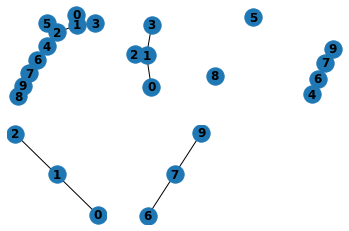

In [12]:
# mini-batch of the all_overlap
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.mini_batch_train_clustering(2) # separate into two clusters
check_clustering(clustering_machine)


In [13]:
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_batch.train(1, 0.0001, 0.1)
gcn_trainer_batch.validate()

(0.75, 0.75)

#### Default whole graph (recombine train nodes)

In [14]:
# default brute force case: recombination whole graph
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.mini_batch_train_clustering(0)      
gcn_trainer_whole = wholeClusterGCNTrainer_sequence(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_whole.train(1, 0.0001, 0.1)
gcn_trainer_whole.validate()

(0.75, 0.75)

#### mini-batch train nodes only in the isolated cluster

node cluster memeber ship:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1}
isolated clusters are:  [[0, 1, 2, 3, 8], [4, 5, 6, 7, 9]]
training nodes global ids are: 
 {0: tensor([0, 2]), 1: tensor([7, 9])}
testing global clusters are:  {0: tensor([8]), 1: tensor([4])}
modeling global clusters are:  [[0, 2, 8], [4, 7, 9]]
validation global clusters are:  [tensor([1, 3]), tensor([5, 6])]
Info about the mini_batch only with training nodes: 
mini train edges of each cluster, global ids:  [{(0, 1), (1, 3), (1, 2)}, {(6, 7), (4, 6), (9, 7)}]
mini train overlapping nodes global ids:  {0: [0, 1, 2, 3], 1: [4, 6, 7, 9]}


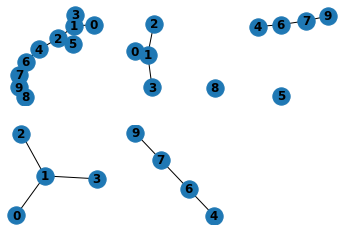

In [15]:
# mini-batch of the isolate
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.general_isolate_clustering(2) 
check_clustering(clustering_machine)


In [16]:
# check_clustering(clustering_machine, True)
gcn_trainer_isolate = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16])
gcn_trainer_isolate.train(1,  0.0001, 0.1)
gcn_trainer_isolate.validate()

(0.75, 0.75)

### Use library data to check the results


In [43]:
def set_clustering_machine(data, partition_num = 10, test_ratio = 0.05, validation_ratio = 0.75):
    connect_edge_index, connect_features, connect_label = filter_out_isolate(data.edge_index, data.x, data.y)
    clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label, partition_num = partition_num)
    clustering_machine.decompose(test_ratio, validation_ratio)
    return clustering_machine

''' Draw the information about the GCN calculating batch size '''
def draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr'):
    cluster_id = clustering_machine.clusters    # a list of cluster indices
    cluster_datapoints = {'cluster_id': cluster_id,  \
                          'train_batch' : [clustering_machine.info_train_batch_size[idx] for idx in cluster_id], \
                          'cluster_size' : [clustering_machine.info_isolate_cluster_size[idx] for idx in cluster_id], \
                         }
                         
    df = pd.DataFrame(data=cluster_datapoints, dtype=np.int32)
    # print(df)
    df_reshape = df.melt('cluster_id', var_name = 'clusters', value_name = 'node_num')
    
    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="cluster_id", y="node_num", hue='clusters', kind='bar', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + comments)
    g.set_xlabels("Cluster ID")
    g.set_ylabels("Number of nodes")
    
    img_name = img_path + data_name + comments
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    g.savefig(img_name, bbox_inches='tight')

### Formal Test

In [44]:
def No_partition_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, \
                     dropout = 0.3, lr = 0.01, weight_decay = 0.01):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # the accumulating neighbor nodes only contain train nodes, no hop neighbors
    clustering_machine.mini_batch_train_clustering(0)
    # 0) train the data as a whole with no parition
    gcn_trainer = wholeClusterGCNTrainer_sequence(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer, dropout = dropout)
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay)
    
#     test_F1, test_accuracy = gcn_trainer.test()
    validation_F1, validation_accuracy = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    return validation_accuracy, validation_F1, time_train_total, time_data_load, gcn_trainer


def Cluster_train_batch_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, neigh_layer = 1, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01):
    """
    # the partition num: will determine the training, testing and validation data
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # defalt to contain 1 layer of neighbors of train nodes
    clustering_machine.mini_batch_train_clustering(neigh_layer)
    
    gcn_trainer = ClusterGCNTrainer_mini_Train(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer, dropout = dropout)
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay)
    
#     test_F1, test_accuracy = gcn_trainer.test()
    validation_F1, validation_accuracy = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    return validation_accuracy, validation_F1, time_train_total, time_data_load, gcn_trainer


def Isolate_clustering_run(local_clustering_machine, data_name, dataset, image_path, input_layer = [16, 16], epochs=300, neigh_layer = 1, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01):
    """
    # the partition num: will determine the training, testing and validation data
    return: test F-1 value, validation F-1 value
    """
    clustering_machine = copy.deepcopy(local_clustering_machine)
    # defalt to contain 1 layer of neighbors of train nodes
    clustering_machine.general_isolate_clustering(neigh_layer)
    gcn_trainer = ClusterGCNTrainer_mini_Train(clustering_machine, dataset.num_node_features, dataset.num_classes, input_layers = input_layer, dropout = dropout)
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay)
    
#     test_F1, test_accuracy = gcn_trainer.test()
    validation_F1, validation_accuracy = gcn_trainer.validate()
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    return validation_accuracy, validation_F1, time_train_total, time_data_load, gcn_trainer



In [45]:
def check_train_loss_converge(clustering_machine, data_name, dataset, image_path,  comments, input_layer = [32, 16], epoch_num = 300, layer_num = 1, dropout = 0.3, lr = 0.0001, weight_decay = 0.01):
    a0, v0, time0, load0, Cluster_train_batch_trainer = Cluster_train_batch_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                                               dropout = dropout, lr = lr, weight_decay = weight_decay)
    draw_Cluster_train_batch = draw_trainer_info(data_name, Cluster_train_batch_trainer, image_path, 'train_batch_' + comments)
    draw_Cluster_train_batch.draw_ave_loss_per_node()
    
    a1, v1, time1, load1, Isolate_clustering_trainer = Isolate_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                                             dropout = dropout, lr = lr, weight_decay = weight_decay)
    draw_Isolate_clustering = draw_trainer_info(data_name, Isolate_clustering_trainer, image_path, 'Isolate_' + comments)
    draw_Isolate_clustering.draw_ave_loss_per_node()
    
    # whole graph version, should not work for the large scale graph
    a2, v2, time2, load2, No_partition_trainer = No_partition_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                                 dropout = dropout, lr = lr, weight_decay = weight_decay)
    draw_No_partition = draw_trainer_info(data_name, No_partition_trainer, image_path, 'whole_' + comments)
    draw_No_partition.draw_ave_loss_per_node()
    


In [46]:
''' Execute the testing program '''
def execute_one(clustering_machine, image_path, repeate_time = 5, input_layer = [32, 16], epoch_num = 300, layer_num = 1, dropout = 0.3, lr = 0.0001, weight_decay = 0.01):
    """
        return all test-F1 and validation-F1 for all four models
    """
#     test_f1 = {}
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    for i in range(repeate_time):
        a0, v0, time0, load0, _ = Cluster_train_batch_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay)
        a1, v1, time1, load1, _ = Isolate_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                        dropout = dropout, lr = lr, weight_decay = weight_decay)
        a2, v2, time2, load2, _ = No_partition_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, 
                                                  dropout = dropout, lr = lr, weight_decay = weight_decay)
    
#         test_f1[i] = [t0, t1, t2]
        validation_accuracy[i] = [a0, a1, a2]
        validation_f1[i] = [v0, v1, v2]
        time_total_train[i] = [time0, time1, time2]
        time_data_load[i] = [load0, load1, load2]
    return validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tests(f1_data, data_name, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id,  \
                'train_batch' : [f1_data[key][0] for key in run_id], \
                'isolate' : [f1_data[key][1] for key in run_id], \
                'whole_graph' : [f1_data[key][2] for key in run_id], \
               }
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels("models")
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')

### Tune hyperparameters

In [62]:
def execute_tuning(tune_params, clustering_machine, image_path, repeate_time = 5, input_layer = [32, 32], epoch_num = 300, layer_num = 1):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = [[Cluster_train_batch_run(clustering_machine, data_name, dataset, image_path, \
            input_layer = tune_val, epochs=epoch_num, neigh_layer = layer_num, \
            dropout = 0.3, lr = 10**(-4), weight_decay = 10**(-3))[:4] for tune_val in tune_params] for i in range(repeate_time)]
    
    for i, lst in enumerate(res):
        validation_accuracy[i] = [val[0] for val in lst]
        validation_f1[i] = [val[1] for val in lst]
        time_total_train[i] = [val[2] for val in lst]
        time_data_load[i] = [val[3] for val in lst]
        
    return validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    run_ids = sorted(target.keys())
    run_data = {'run_id': run_ids}
    tmp = {str(key) : [target[run_id][i] for run_id in run_ids] for i, key in enumerate(tune_params)}
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Use data from pytorch geometric datasets

In [63]:
local_data_root = '/media/xiangli/storage1/projects/tmpdata/'
test_folder_name = 'check_load_time_vs_netnum/train_10%_half_decay/'

### Cora dataset

In [49]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[], [16], [16, 16], [16, 16, 16], [16, 16, 16, 16], [16, 16, 16, 16, 16], [16, 16, 16, 16, 16, 16]]

#### Checking training loss

Start checking train loss for partition num: 4 hop layer: 1
Start checking train loss for partition num: 4 hop layer: 2
Start checking train loss for partition num: 4 hop layer: 3
Start checking train loss for partition num: 4 hop layer: 4


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Start checking train loss for partition num: 4 hop layer: 5


/media/xiangli/storage1/projects/large_scale_GCN/neighbor_sampling/utils.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Start checking train loss for partition num: 4 hop layer: 6
Start checking train loss for partition num: 4 hop layer: 7


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

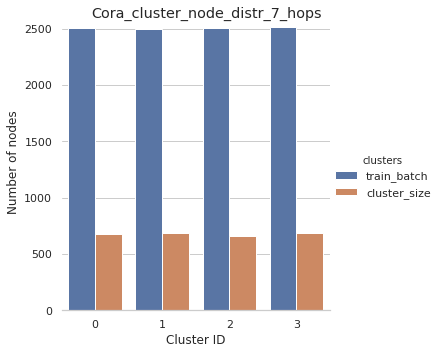

In [50]:
# check convergence

for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
        check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                 dropout = 0.1, lr = 0.0001, weight_decay = 0.1)
        clustering_machine.mini_batch_train_clustering(hop_layer)
        draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')

#### Output accuracy, F1, time (train, load)

Start running for partition num: 4 hop layer 1
Start running for partition num: 4 hop layer 2
Start running for partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib

Start running for partition num: 4 hop layer 4


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 5


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 6


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 7


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

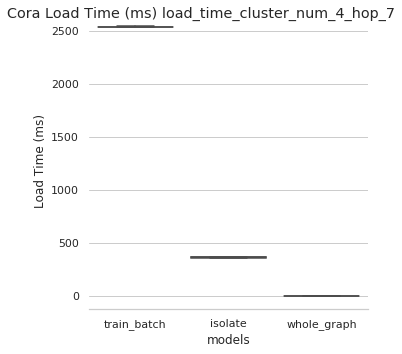

In [51]:
for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

        validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                          dropout = 0.1, lr = 0.0001, weight_decay = 0.1)
        
        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Accuracy')
        validation_f1 = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'F1 score')
        
        time_train = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Train Time (ms)')
        time_load = store_data_multi_tests(time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Load Time (ms)')
        

### CiteSeer Dataset

In [52]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[], [16], [16, 16], [16, 16, 16], [16, 16, 16, 16], [16, 16, 16, 16, 16], [16, 16, 16, 16, 16, 16]]

#### Checking train loss

Start checking train loss for partition num: 4 hop layer: 1
Start checking train loss for partition num: 4 hop layer: 2
Start checking train loss for partition num: 4 hop layer: 3
Start checking train loss for partition num: 4 hop layer: 4


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Start checking train loss for partition num: 4 hop layer: 5


/media/xiangli/storage1/projects/large_scale_GCN/neighbor_sampling/utils.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Start checking train loss for partition num: 4 hop layer: 6
Start checking train loss for partition num: 4 hop layer: 7


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

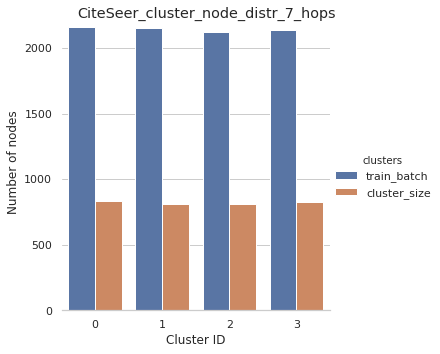

In [53]:
# check convergence

for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
        check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                 dropout = 0.5, lr = 0.0001, weight_decay = 0.1)
        clustering_machine.mini_batch_train_clustering(hop_layer)
        draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')

Start running for partition num: 4 hop layer 1
Start running for partition num: 4 hop layer 2
Start running for partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib

Start running for partition num: 4 hop layer 4


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 5


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 6


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 7


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

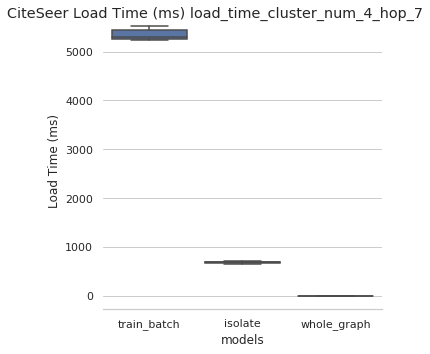

In [54]:
for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

        validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                          dropout = 0.5, lr = 0.0001, weight_decay = 0.1)
        
        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Accuracy')
        validation_f1 = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'F1 score')
        
        time_train = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Train Time (ms)')
        time_load = store_data_multi_tests(time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Load Time (ms)')
        

### PubMed dataset

In [64]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[], [16], [16, 16], [16, 16, 16], [16, 16, 16, 16], [16, 16, 16, 16, 16], [16, 16, 16, 16, 16, 16]]

Start checking train loss for partition num: 4 hop layer: 1
Start checking train loss for partition num: 4 hop layer: 2
Start checking train loss for partition num: 4 hop layer: 3
Start checking train loss for partition num: 4 hop layer: 4


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Start checking train loss for partition num: 4 hop layer: 5


/media/xiangli/storage1/projects/large_scale_GCN/neighbor_sampling/utils.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Start checking train loss for partition num: 4 hop layer: 6
Start checking train loss for partition num: 4 hop layer: 7


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 464.35x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

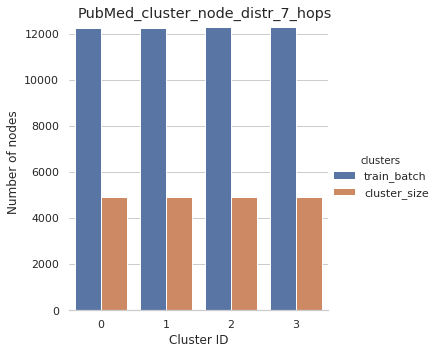

In [65]:
# check convergence

for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
        check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                 dropout = 0.3, lr = 0.0001, weight_decay = 0.001)
        clustering_machine.mini_batch_train_clustering(hop_layer)
        draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')

Start running for partition num: 4 hop layer 1
Start running for partition num: 4 hop layer 2
Start running for partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib

Start running for partition num: 4 hop layer 4


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 5


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 6


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 4 hop layer 7


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

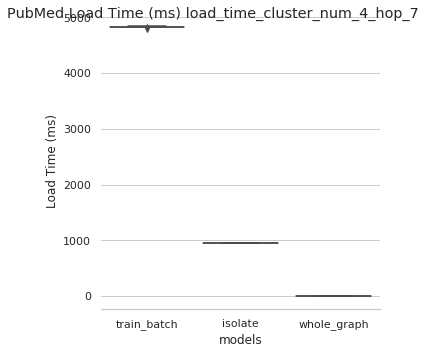

In [66]:
for partn in partition_nums:
    for GCN_layer in layers:
        net_layer = len(GCN_layer) + 1
        hop_layer = net_layer
        clustering_machine = set_clustering_machine(data, partition_num = partn, test_ratio = 0.05, validation_ratio = 0.85)
        print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
        img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

        validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                          dropout = 0.3, lr = 0.0001, weight_decay = 0.001)
        
        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Accuracy')
        validation_f1 = store_data_multi_tests(validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'F1 score')
        
        time_train = store_data_multi_tests(time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Train Time (ms)')
        time_load = store_data_multi_tests(time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'Load Time (ms)')
        

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)